In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

### Tidal parameters for Belfast, Maine

In [2]:
# Details for nearby tide station
labs = ['M2', 'N2', 'S2', 'K1', 'O1']
amp = [1.572, 0.346, 0.238, 0.141, 0.110] # meters
pha_deg = [306.9, 279.1, 338.0, 118.5, 104.6] # degrees
pha = [p * (np.pi / 180) for p in pha_deg] # rad
spd = [28.984104, 28.43973, 30.0, 15.041069, 13.943035] # deg/hr
T = [360 / s for s in spd] # period [hr]

### Functions for iterating across tidal cycles

In [3]:
# Take a piece of the prediction between two peaks
def get_slices(df):
    '''
    df (array) time as first column, water heights as second
    return list of sliced arrays
    '''
    peaks, _ = find_peaks(df[:, 1])
    troughs, _ = find_peaks(-df[:, 1])
    
    main = []
    
    for i in range(len(peaks)-1):
        # Slice predictions around peaks (include all columns)
        sample = df[peaks[i]:peaks[i+1]]

        main.append(sample)
        
    return main, peaks, troughs

def get_start(df, min_head):
    '''
    pred (array) sliced within two peaks
    trough (int) index of trough within slice
    min_head (float) minimum height of water to begin flow
    t_step (float) step size to scale index by to return time
    '''
    # Select water height column
    pred = df[:, 1]
    
    # Find midway point to constrain search space to ~half of range
    mid = int(len(pred) / 2)
    
    # want to find the time when the minimum head is first achieved
    search_range = pred[:mid]

    # Find distance from peak for points in search range
    height_diff = -(search_range - pred[0])

    # Find difference between heights and target head
    head_diff = (abs(height_diff - min_head))

    # Find index where head is closest to min_head
    i_wait = np.where(head_diff == min(head_diff))[0][0]
    
    return i_wait

def get_slope(df, i_wait):
    '''
    df (array)
    i_wait (int) index
    '''
    # Slope assumed to be negative
    slope = (df[i_wait + 1, 1] - df[i_wait - 1, 1]) / (df[i_wait + 1, 0] - df[i_wait - 1, 0])
    slope = slope - slope * 0.6
    return slope

def get_end(df, min_head, i_wait, slope):
    '''
    df (array) sliced
    '''
    t = df[:,0]
    t_start = df[i_wait, 0]
    high_water = df[0, 1]
    
    # draw water level across values in range
    y = slope * (t - t_start) + high_water

    # find crossing point of internal and external water levels
    cross = np.where(df[:, 1] > y)[0][0]

    # constrain search range within t_start and intersection
    # Offset by three time units to make sure not to find the first point (assumes this is not too many for tide cycle)
    offset = 3
    search_range = df[i_wait + offset:cross, 1]
    search_y = y[i_wait + offset:cross]
    
    # Find distance from peak for points in search range
    height_diff = (search_y - search_range)
    
    # Find difference between heights and target head
    head_diff = (abs(height_diff - min_head))

    # Find time where head is closest to min_head
    end_range = np.where(head_diff == min(head_diff))[0][0]
    
    # Account for indices which were previously trimmed
    i_end = end_range + i_wait + offset
    
    return i_end

## Tidal Prediction

In [4]:
rho = 1025 # [kg/m^3]
A_l = 6.5 * 1000 * 1000 # [m^2]
g = 9.81 # [m/s^2]

# Head required to start allowing flow
min_head = 2 # [m]

# Define how many days to forecast, time intervals
days = 30
t_step = 0.2 # [hr]

start = 0
stop = 24 * days # [hr]

# Time series for forecast
t = np.arange(start = start, stop = stop, step = t_step)

# Make prediction as sum of constituents across time series
pred = 0
for n in range(len(amp)):
    A = amp[n]
    p = pha[n]
    T_ = T[n]
    lab = labs[n]
    pred += A*np.cos(2*np.pi*t/T_ - p)
    
t = t.reshape(t.shape[0], 1)
pred = pred.reshape(pred.shape[0], 1)
df = np.concatenate((t, pred), axis = 1)

### Full time series of tidal prediction

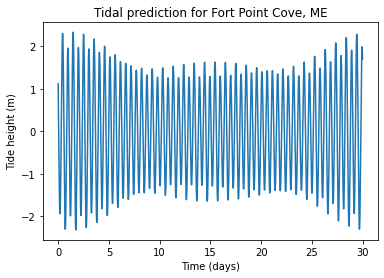

In [5]:
plt.plot(df[:, 0] * (1/24), df[:, 1])
plt.xlabel('Time (days)')
plt.ylabel('Tide height (m)')
plt.title('Tidal prediction for Fort Point Cove, ME')
plt.show()

### One cycle

In [6]:
main, peaks, troughs = get_slices(df)
s = main[0]
i_wait = get_start(s, min_head)
slope = get_slope(s, i_wait)
i_end = get_end(s, min_head, i_wait, slope)

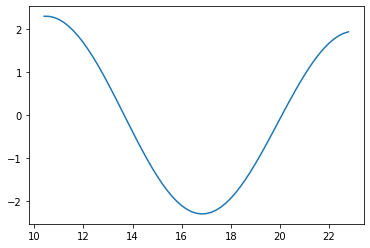

In [7]:
plt.plot(s[:, 0], s[:, 1])
plt.show()

### Average potential energy per tidal cycle

In [8]:
# Mean height
H_mean = (df[peaks, 1] - df[troughs, 1]).sum() / len(peaks)

rho = 1025 # [kg/m^3]
A_l = 6.5 * 1000 * 1000 # [m^2]
g = 9.81 # [m/s^2]

# Potential energy
(1/2 * rho * g * A_l * H_mean**2) / 10**9 # [GJ]

350.03497890809996

### Energy available in one cycle

In [9]:
# Head required to start allowing flow. This is an initial guess
min_head = 2 # [m]

# Turbine efficiency
eta = 0.80

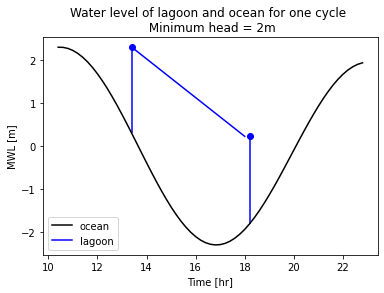

In [10]:
main, peaks, troughs = get_slices(df)
s = main[0]
i_start = get_start(s, min_head)
slope = get_slope(s, i_start)
i_end = get_end(s, min_head, i_start, slope)

t = s[i_start:i_end, 0]

t_start = s[i_start, 0]
lagoon_high = s[0, 1]
ocean_high = s[i_start, 1]
y = slope * (t - t_start) + lagoon_high

t_end = s[i_end, 0]
lagoon_low = y[-1]
ocean_low = s[i_end, 1]

plt.plot(s[:, 0], s[:, 1], 'black', label = 'ocean')
plt.plot(t, y, 'blue', label = 'lagoon')
plt.plot(t_start, lagoon_high, 'bo')
plt.plot(t_end, lagoon_low, 'bo')
plt.vlines(t_start, ocean_high, lagoon_high, 'blue')
plt.vlines(t_end, ocean_low, lagoon_low, 'blue')
plt.xlabel('Time [hr]')
plt.ylabel('MWL [m]')
plt.legend()
plt.title('Water level of lagoon and ocean for one cycle \n Minimum head = 2m')
plt.show()

### Average energy capture for 24 hour period based on long term tidal prediction

In [11]:
def daily_power(df, min_head, days):
    main, peaks, troughs = get_slices(df)
    
    cycle_energy = []
    for s in main:
    # Initial functions find time within operating range, slope of water height line
        i_start = get_start(s, min_head)
        slope = get_slope(s, i_start) # [m/h]
        i_end = get_end(s, min_head, i_start, slope)
    # Time series while lagoon water level is dropping
        t = s[i_start:i_end, 0]
        t_start = s[i_start, 0]
        lagoon_high = s[0, 1]
    # Lagoon water level during production
        y = slope * (t - t_start) + lagoon_high
    # Find area under curve
        diff = y - s[i_start: i_end, 1]
        auc = np.trapz(diff, t)
    # Make list of energy produced during every cycle [MWh]
        cycle_energy.append(- (eta * rho * g * auc * A_l * slope) / 10 ** 6 / 3600)
        
    return np.array(cycle_energy).sum() / days

p = daily_power(df, min_head, days)
print(p, " [MWh]")

70.58171340497391  [MWh]


### Finding optimal minimum head to start production

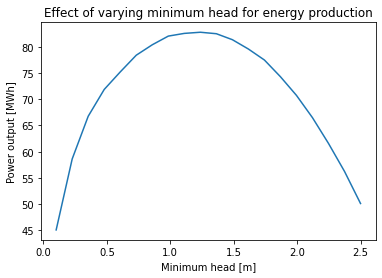

In [12]:
heads = np.linspace(0.1, 2.5, 20)
p_ = []
for head in heads:
    p_.append(daily_power(df, head, days))
plt.plot(heads, p_)
plt.xlabel("Minimum head [m]")
plt.ylabel("Power output [MWh]")
plt.title("Effect of varying minimum head for energy production")
plt.show()

In [13]:
np.array(p_)
i,  = np.where(p_==max(p_))[0]
print("Best min_head: " , heads[i], "[m]")

Best min_head:  1.236842105263158 [m]


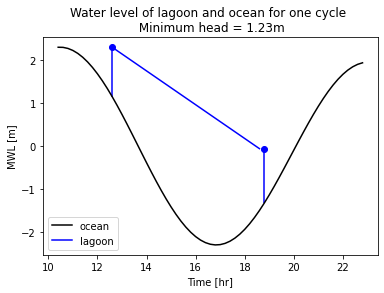

In [14]:
min_head = 1.23

main, peaks, troughs = get_slices(df)
s = main[0]
i_start = get_start(s, min_head)
slope = get_slope(s, i_start)
i_end = get_end(s, min_head, i_start, slope)

t = s[i_start:i_end, 0]

t_start = s[i_start, 0]
lagoon_high = s[0, 1]
ocean_high = s[i_start, 1]
y = slope * (t - t_start) + lagoon_high

t_end = s[i_end, 0]
lagoon_low = y[-1]
ocean_low = s[i_end, 1]

plt.plot(s[:, 0], s[:, 1], 'black', label = 'ocean')
plt.plot(t, y, 'blue', label = 'lagoon')
plt.plot(t_start, lagoon_high, 'bo')
plt.plot(t_end, lagoon_low, 'bo')
plt.vlines(t_start, ocean_high, lagoon_high, 'blue')
plt.vlines(t_end, ocean_low, lagoon_low, 'blue')
plt.xlabel('Time [hr]')
plt.ylabel('MWL [m]')
plt.legend()
plt.title('Water level of lagoon and ocean for one cycle \n Minimum head = 1.23m')
plt.show()

In [15]:
p = daily_power(df, min_head, days)
print(p, " [MWh]")

82.77175095659585  [MWh]


### Households which could be supported

In [16]:
# Annual energy production
annual_p = p * 365 # [MWh / year]
res_consumption = 31.0655 * 10**6 # [MWh/year]
me_pop = 1.344 * 10**6 # [person]
consumption_person = res_consumption / me_pop # [MWh/year/person]
house_size = 2.15 # [person/house]
consumption_house = consumption_person * house_size # [MWh/year/house]

powered_homes = annual_p / consumption_house # [house]
powered_homes

607.9354484581927